<a href="https://colab.research.google.com/github/luisflorenz/jupyter_data/blob/main/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digit Recognizer
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

## Training Deep Neural Networks on a GPU

### Preparing the Data
Let's begin by installing and importing the required modules and classes from torch, torchvision, numpy, and matplotlib.

In [ ]:
import os
import csv
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
! pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/competitions/digit-recognizer'

In [ ]:
od.download(dataset_url)

Skipping, found downloaded files in "./digit-recognizer" (use force=True to force download)


In [ ]:
data_dir = 'digit-recognizer'

In [ ]:
print(os.listdir(data_dir))

['sample_submission.csv', 'test.csv', 'train.csv']


In [ ]:
!ls -lh {data_dir}

total 123M
-rw-r--r-- 1 root root 236K Dec 21 15:03 sample_submission.csv
-rw-r--r-- 1 root root  49M Dec 21 15:03 test.csv
-rw-r--r-- 1 root root  74M Dec 21 15:03 train.csv


In [ ]:
train_dataset = pd.read_csv('digit-recognizer/train.csv')
train_dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(train_dataset)

42000

In [ ]:
train_dataset.shape

(42000, 785)

In [ ]:
train_dataset.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [ ]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
train_dataset.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [ ]:
test_dataset = pd.read_csv('digit-recognizer/test.csv')
test_dataset.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_dataset.shape

(28000, 784)

In [ ]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [ ]:
test_dataset.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

In [ ]:
test_dataset.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
sample_sub = pd.read_csv('digit-recognizer/sample_submission.csv')
sample_sub


,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


## Prepare the dataset for training.

In [ ]:
num_cols = len(train_dataset.columns)
num_cols

785

Let's make a copy for manupitate de dataframe

In [ ]:
train_df = train_dataset.copy()

In [ ]:
test_df = test_dataset.copy()

In [ ]:
inputs = torch.tensor(train_df.drop(columns="label").values, dtype=torch.float32)
targets = torch.tensor(train_df["label"].values, dtype=torch.long)

we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a TensorDataset.



In [ ]:
inputs = inputs / 255.0
inputs = inputs.view(-1, 1, 28, 28)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataloaders

In [ ]:
batch_size = 64

In [ ]:
train_ds = TensorDataset(X_train.to(device), y_train.to(device))
test_ds = TensorDataset(X_test.to(device), y_test.to(device))

In [ ]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

### Logistic regression model

Let's define the model by extending the nn.Module class from PyTorch.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.c1 = nn.Conv2d(1, 32, kernel_size=3)
        self.c2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.c1(x))
        x = self.max_pool2d(x)
        x = self.relu(self.c2(x))
        x = self.max_pool2d(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN().to(device)

We also need to define an accuracy function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in validation_step above.

In [ ]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 16

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_dl:
        optimizer.zero_grad()
        y_hat = model(inputs)
        loss = criterion(y_hat, labels)
        loss.backward()
        optimizer.step()

    print(f"epoch: {epoch}, loss: {loss}")

epoch: 0, loss: 0.034584663808345795
epoch: 1, loss: 0.2188785821199417
epoch: 2, loss: 0.10086391121149063
epoch: 3, loss: 0.03056962601840496
epoch: 4, loss: 0.01968732662498951
epoch: 5, loss: 0.019406458362936974
epoch: 6, loss: 0.012073428370058537
epoch: 7, loss: 0.005986665841192007
epoch: 8, loss: 0.007722692564129829
epoch: 9, loss: 0.030236223712563515
epoch: 10, loss: 0.0029068682342767715
epoch: 11, loss: 0.018777402117848396
epoch: 12, loss: 0.01246076263487339
epoch: 13, loss: 0.0012828815961256623
epoch: 14, loss: 0.01025730837136507
epoch: 15, loss: 0.0002590899239294231


y: 8, y_hat: 8


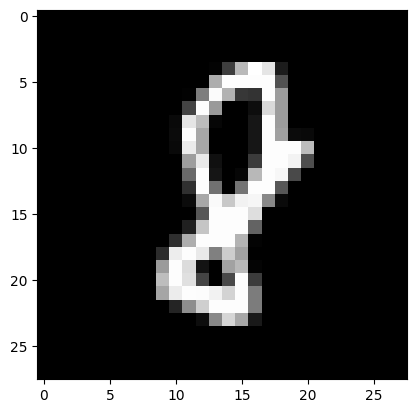

y: 8, y_hat: 5


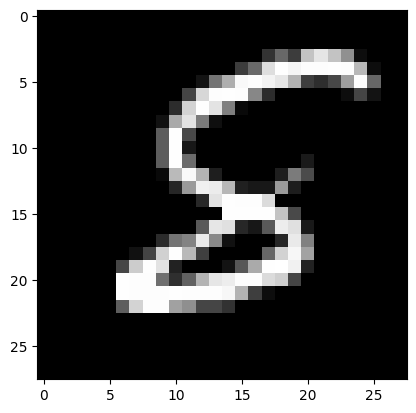

y: 1, y_hat: 1


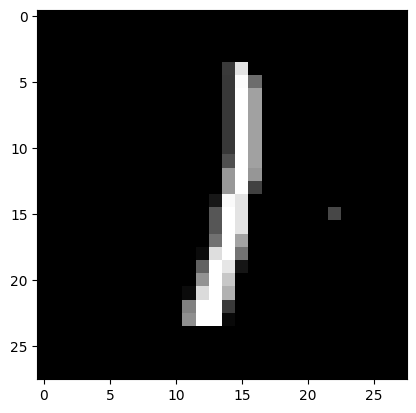

y: 9, y_hat: 9


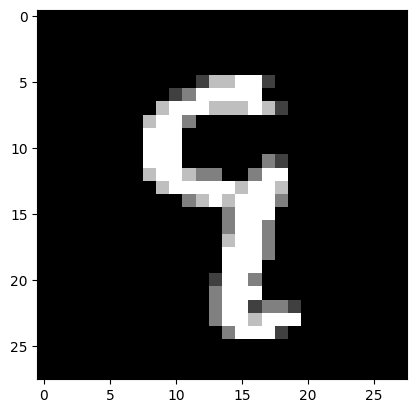

y: 2, y_hat: 2


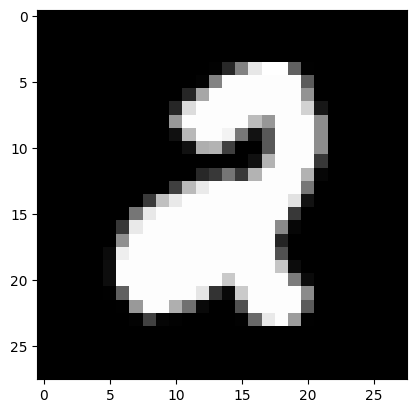

y: 3, y_hat: 7


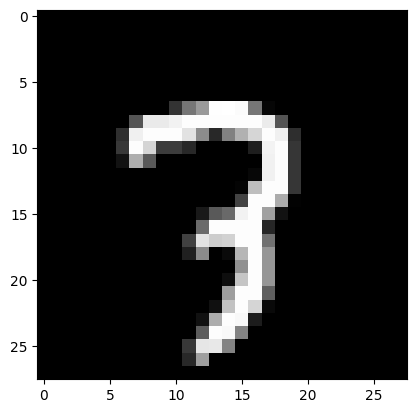

y: 8, y_hat: 8


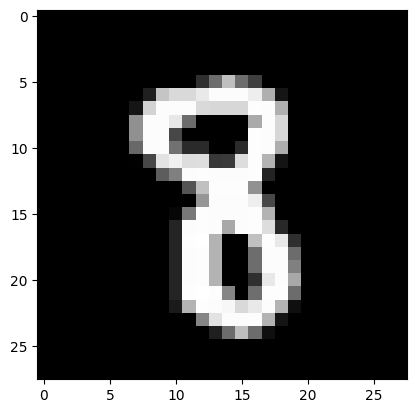

y: 4, y_hat: 4


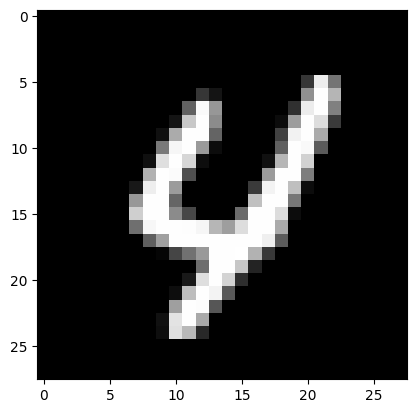

y: 7, y_hat: 7


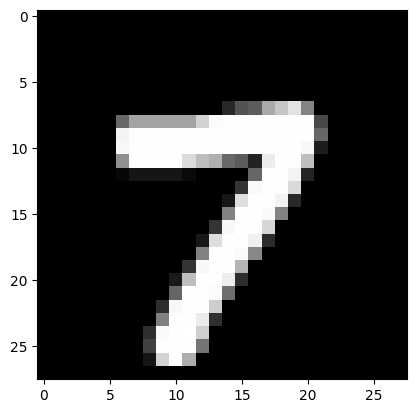

y: 5, y_hat: 5


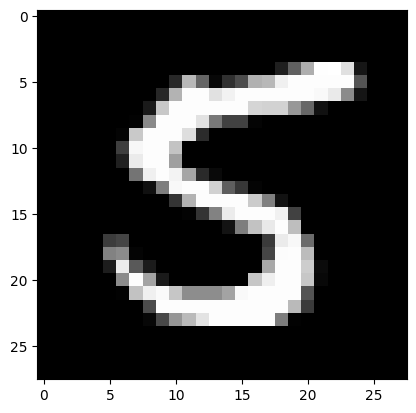

y: 9, y_hat: 9


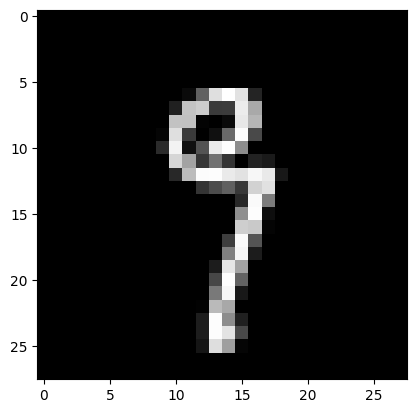

y: 1, y_hat: 1


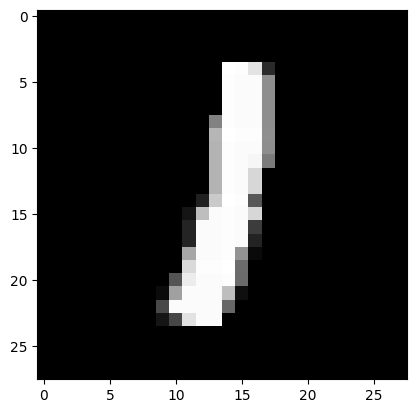

y: 6, y_hat: 6


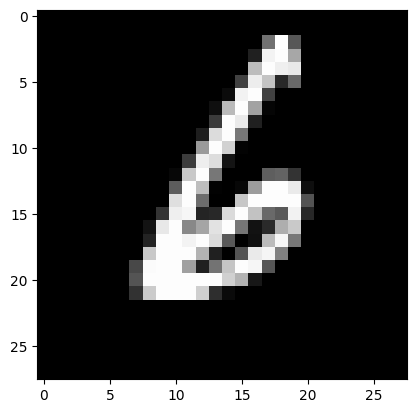

y: 1, y_hat: 1


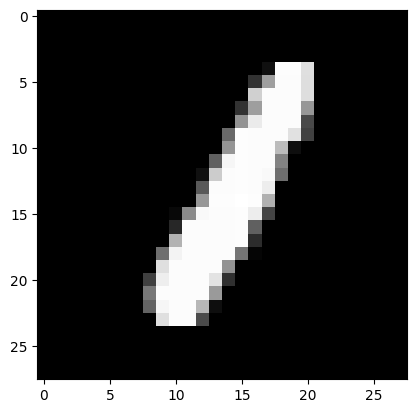

y: 5, y_hat: 5


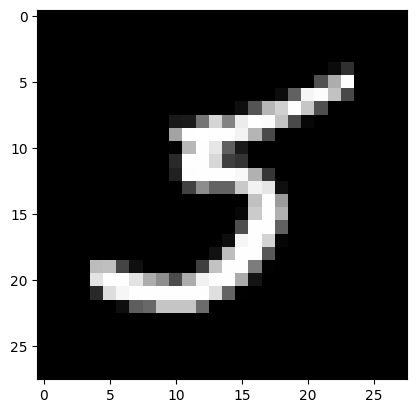

y: 1, y_hat: 1


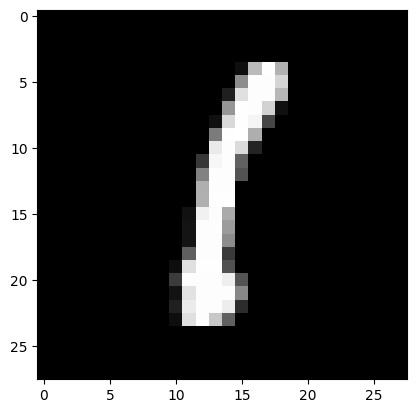

y: 8, y_hat: 8


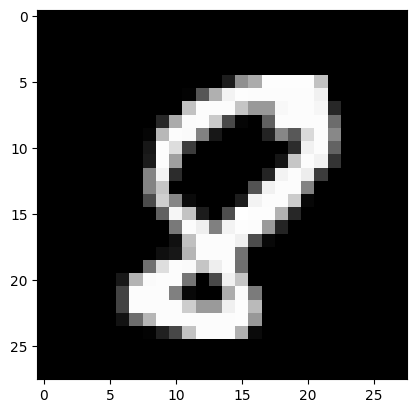

y: 6, y_hat: 6


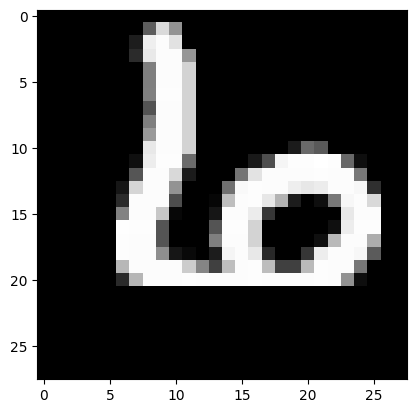

y: 8, y_hat: 8


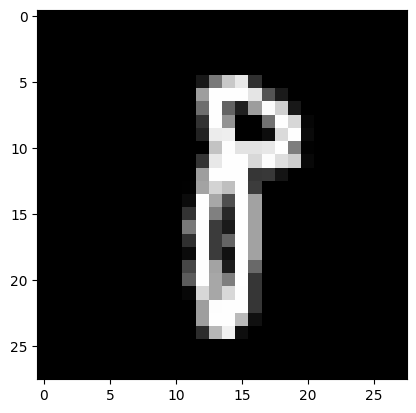

y: 3, y_hat: 3


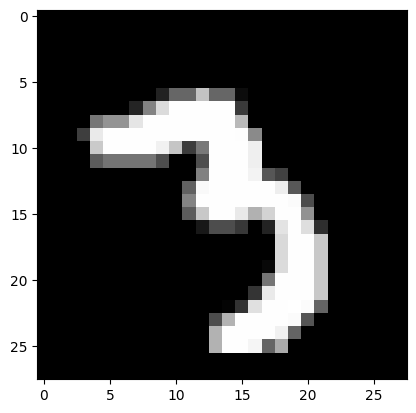

y: 9, y_hat: 9


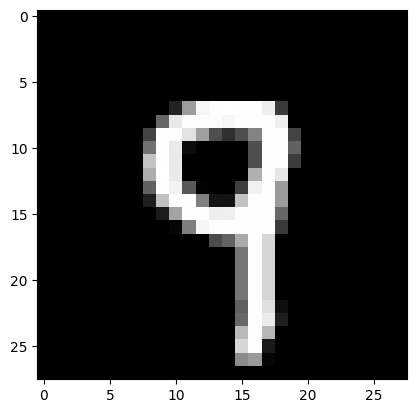

y: 0, y_hat: 0


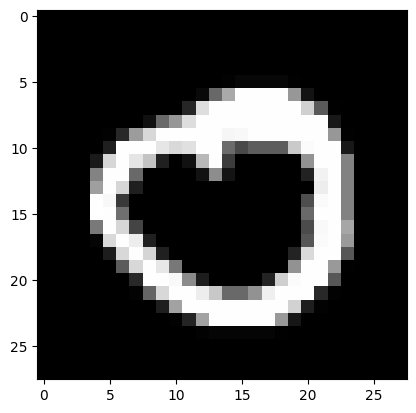

y: 4, y_hat: 4


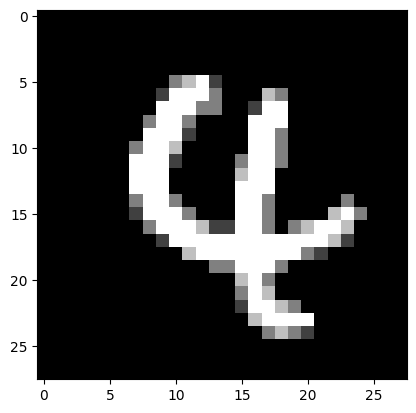

y: 5, y_hat: 5


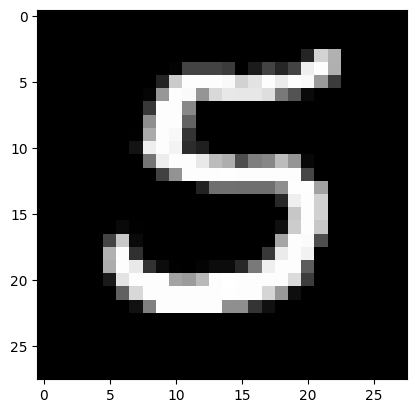

y: 7, y_hat: 7


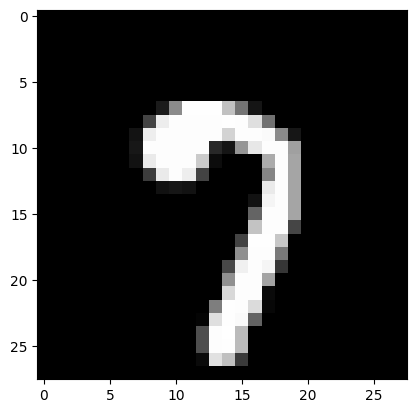

y: 5, y_hat: 5


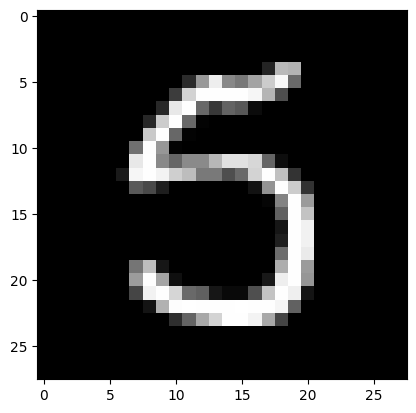

y: 3, y_hat: 3


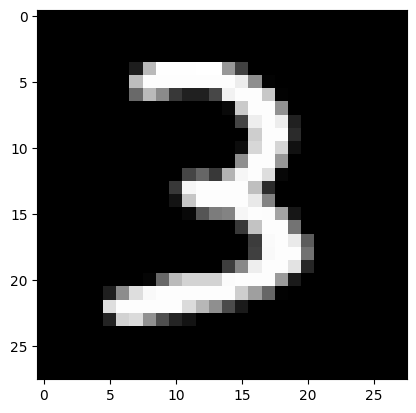

y: 6, y_hat: 6


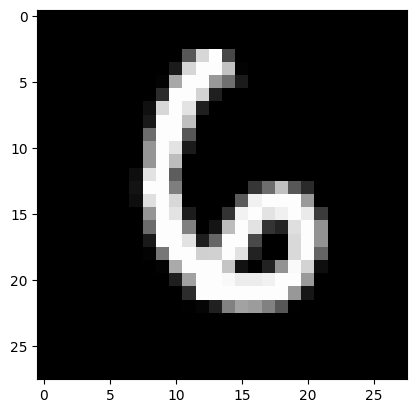

y: 3, y_hat: 3


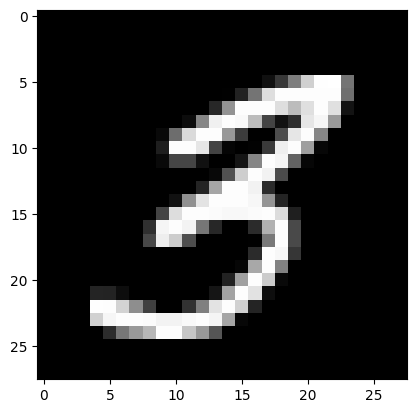

y: 8, y_hat: 8


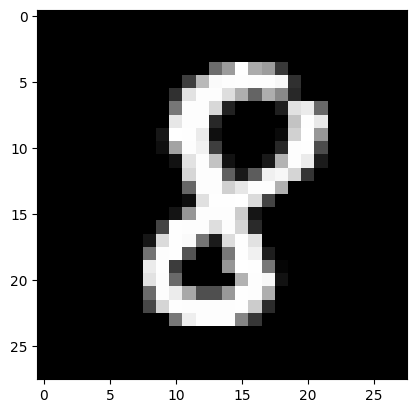

y: 3, y_hat: 3


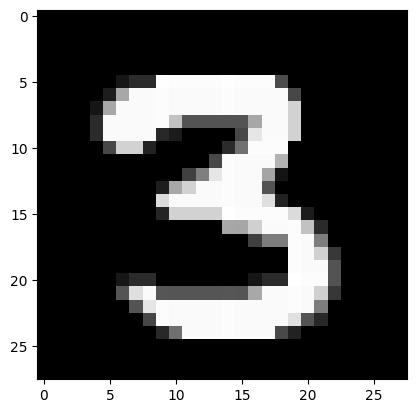

y: 2, y_hat: 2


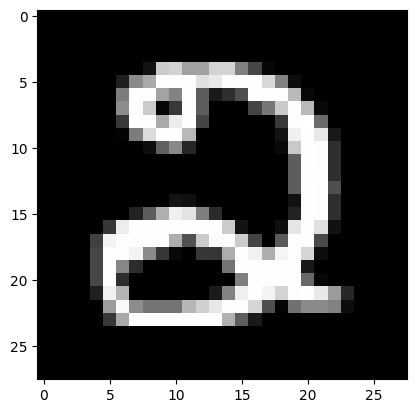

y: 3, y_hat: 3


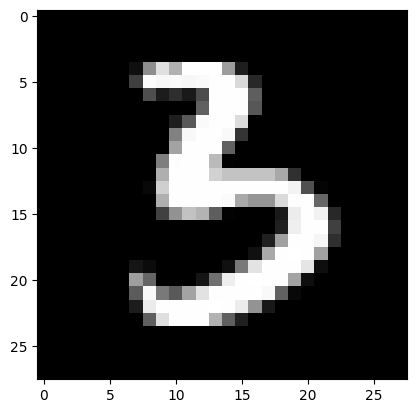

y: 7, y_hat: 7


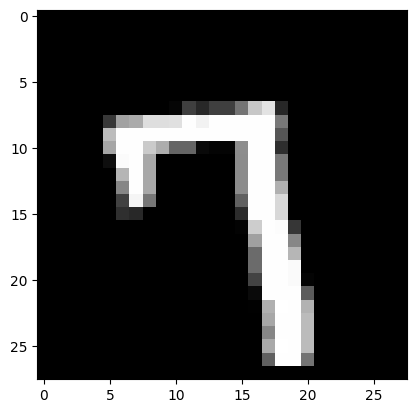

y: 2, y_hat: 2


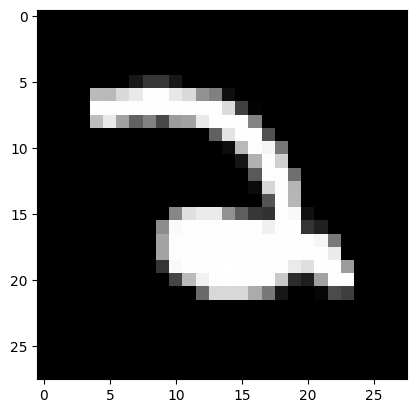

y: 6, y_hat: 6


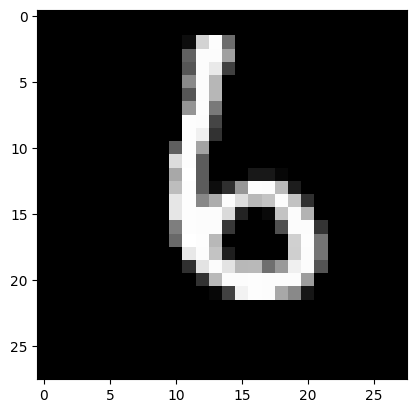

y: 5, y_hat: 5


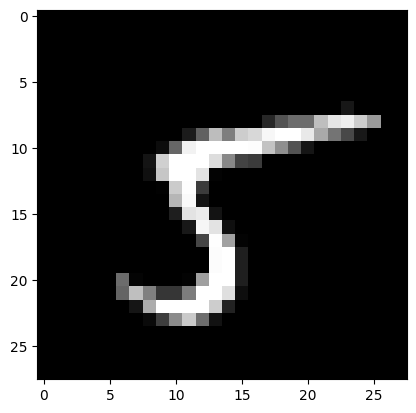

y: 4, y_hat: 4


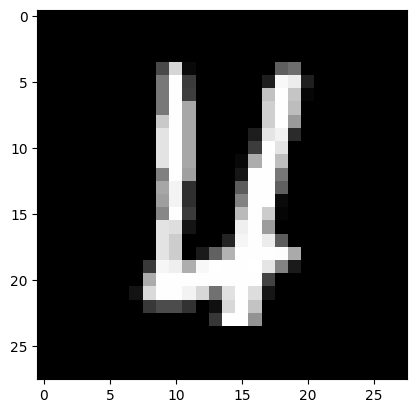

y: 1, y_hat: 1


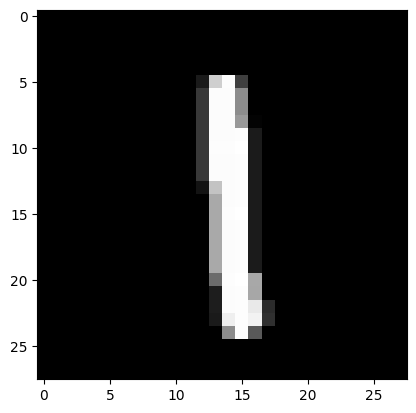

y: 3, y_hat: 3


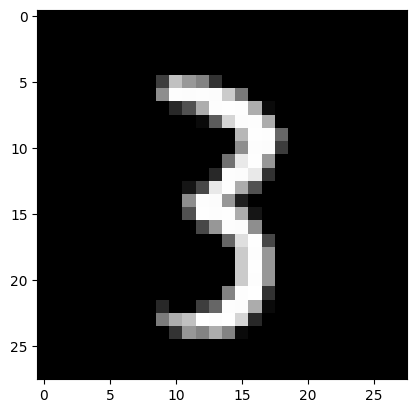

y: 8, y_hat: 8


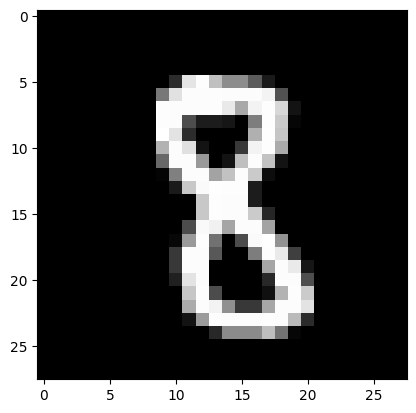

y: 9, y_hat: 9


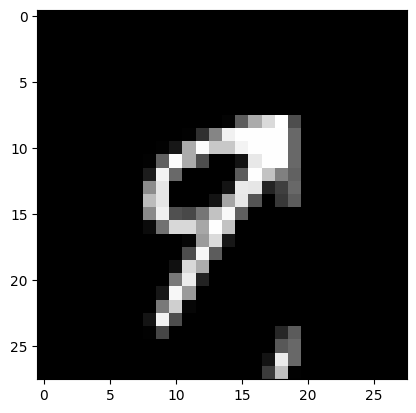

y: 3, y_hat: 3


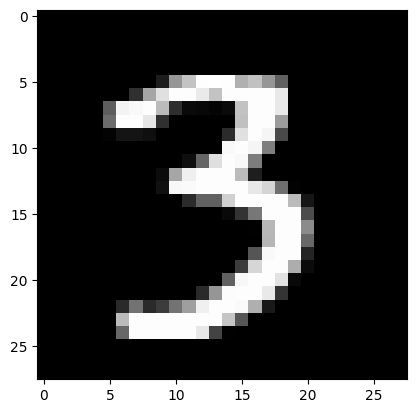

y: 2, y_hat: 2


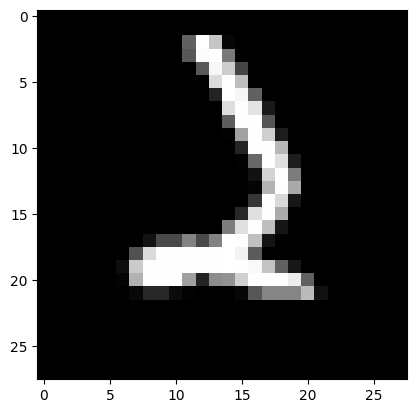

y: 2, y_hat: 2


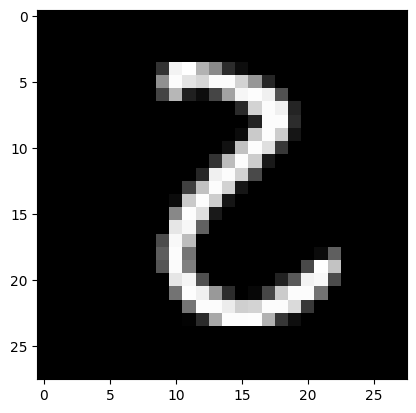

y: 1, y_hat: 1


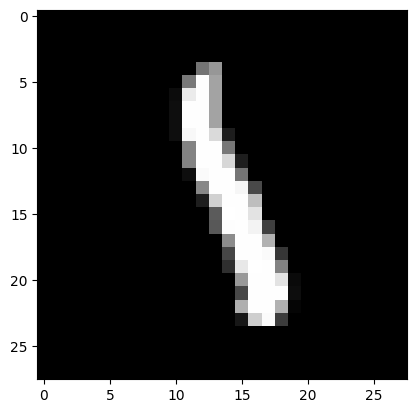

y: 4, y_hat: 4


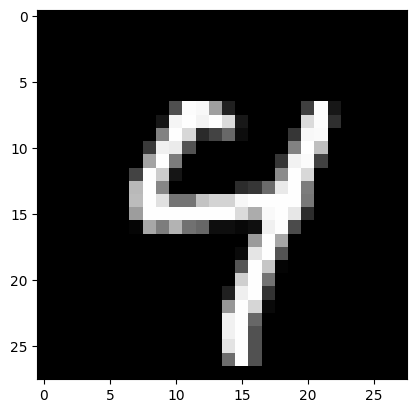

y: 3, y_hat: 3


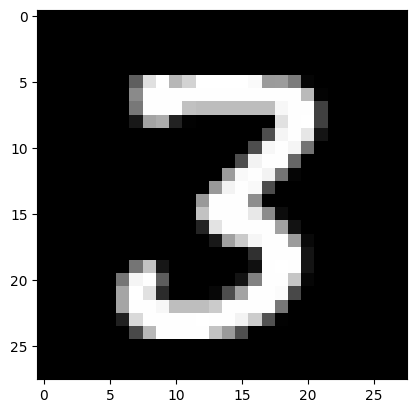

y: 4, y_hat: 4


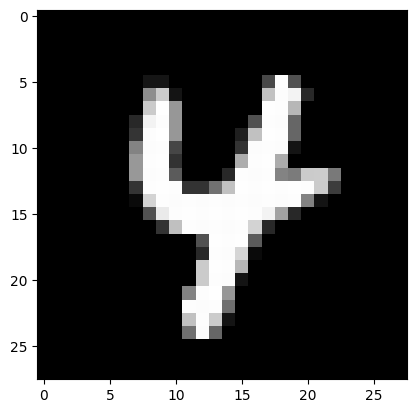

y: 8, y_hat: 8


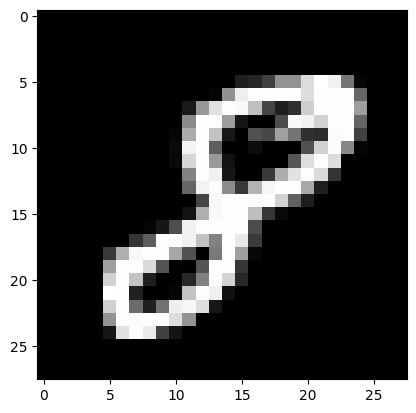

y: 0, y_hat: 0


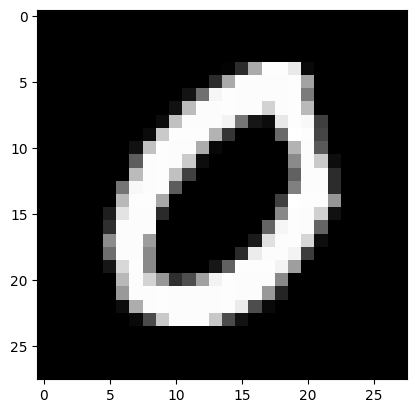

y: 3, y_hat: 3


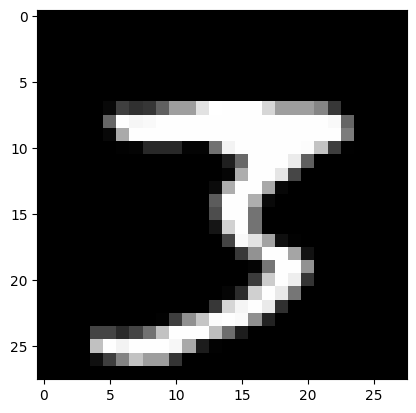

y: 9, y_hat: 9


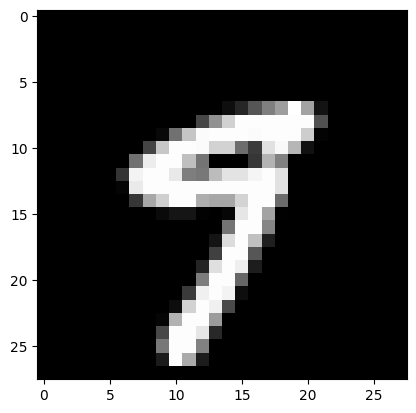

y: 5, y_hat: 5


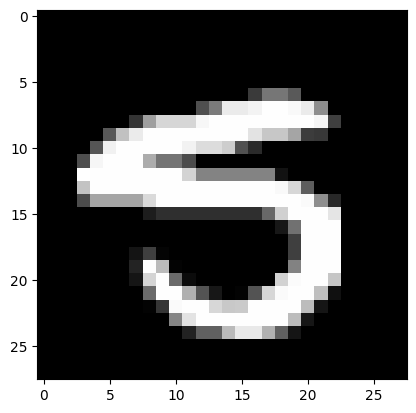

y: 5, y_hat: 5


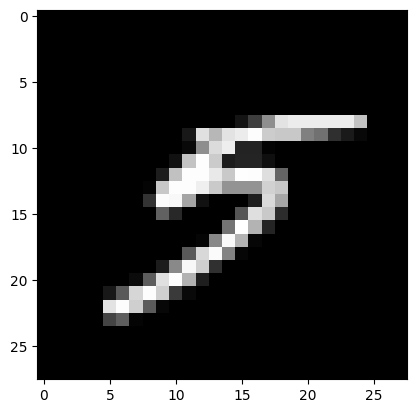

y: 7, y_hat: 7


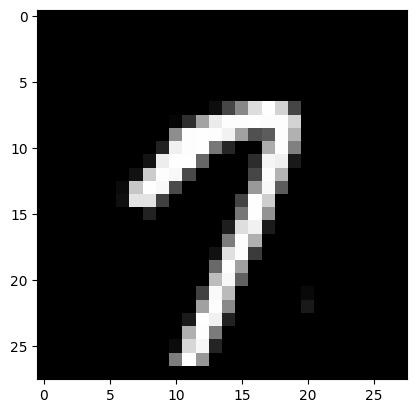

y: 9, y_hat: 9


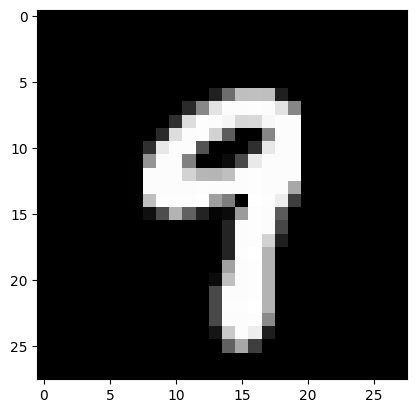

y: 8, y_hat: 8


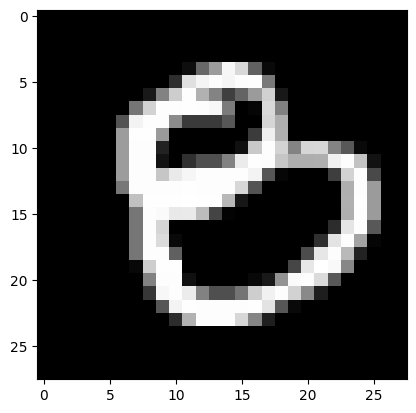

y: 6, y_hat: 6


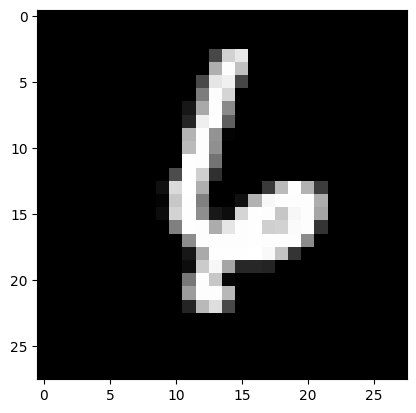

y: 4, y_hat: 4


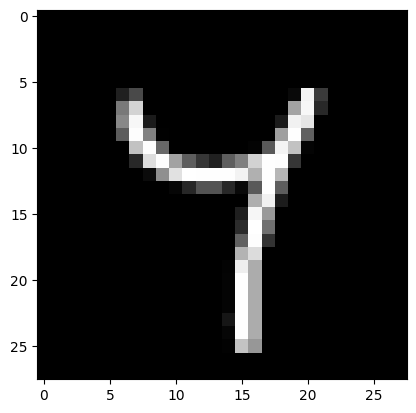

y: 6, y_hat: 6


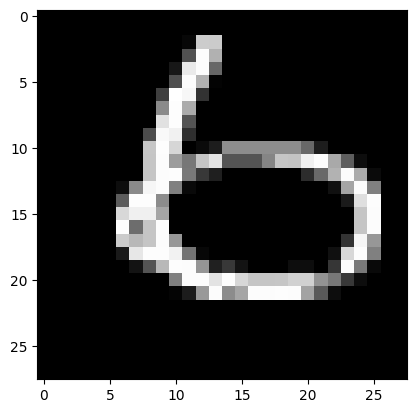

y: 6, y_hat: 6


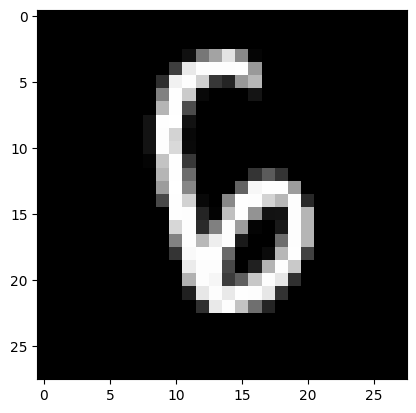

y: 3, y_hat: 3


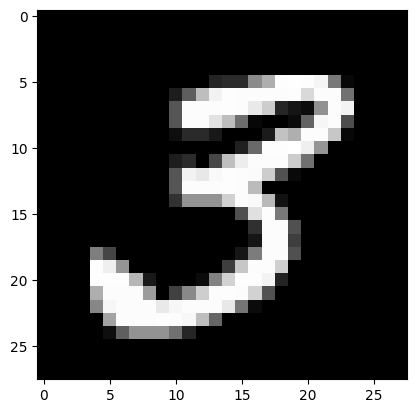

y: 0, y_hat: 0


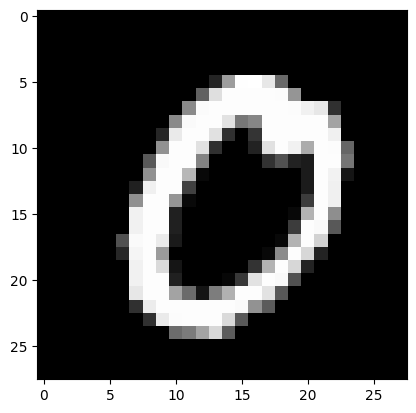

y: 1, y_hat: 1


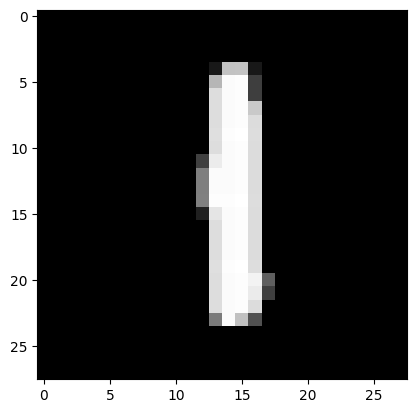

y: 3, y_hat: 3


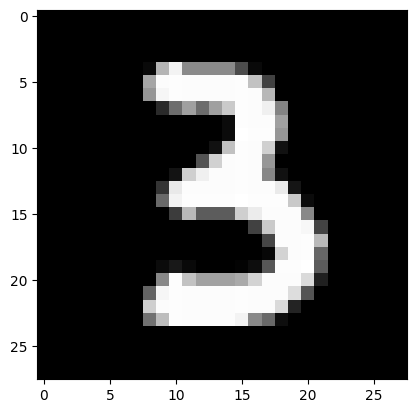

y: 1, y_hat: 1


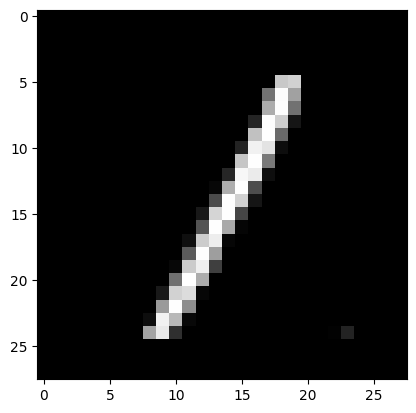

y: 7, y_hat: 7


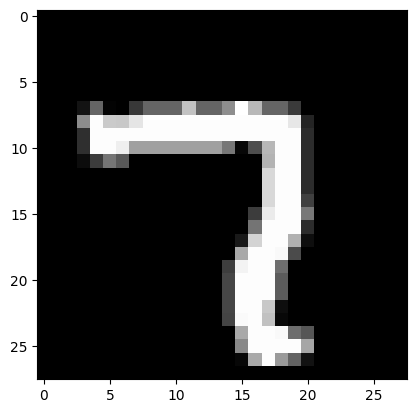

y: 6, y_hat: 6


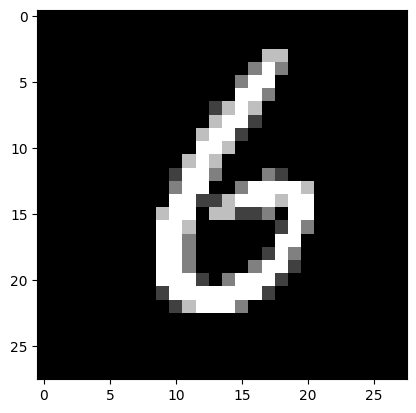

y: 7, y_hat: 7


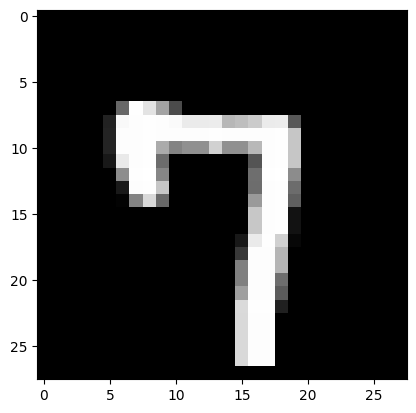

y: 7, y_hat: 7


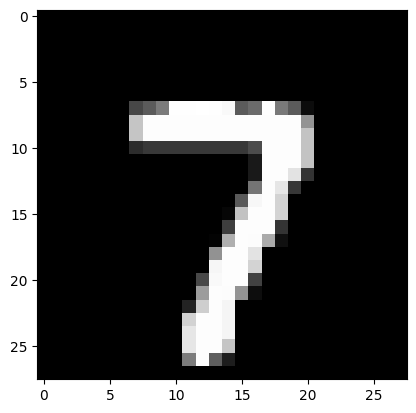

y: 2, y_hat: 2


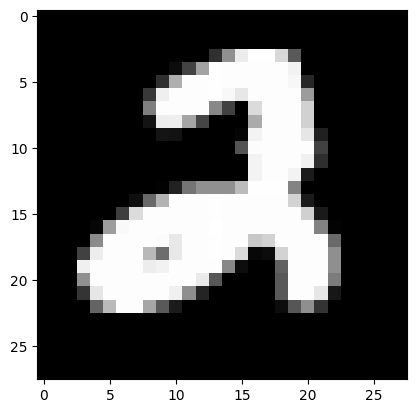

y: 7, y_hat: 7


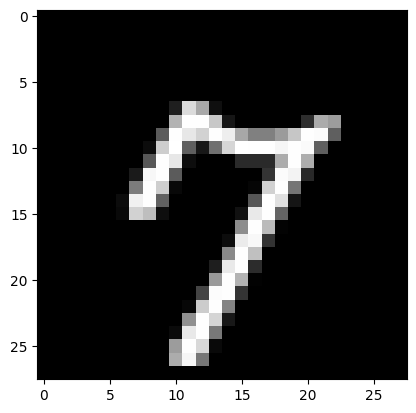

y: 6, y_hat: 6


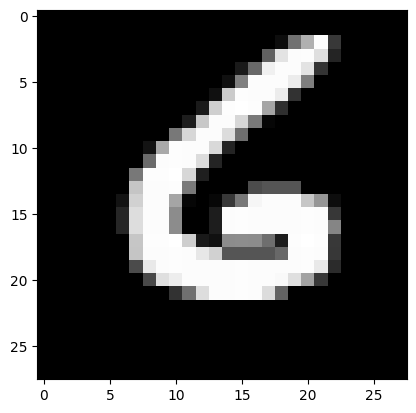

y: 1, y_hat: 1


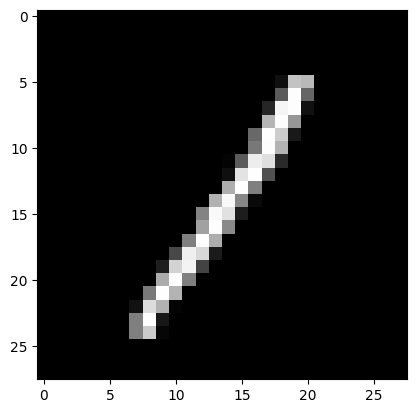

y: 9, y_hat: 9


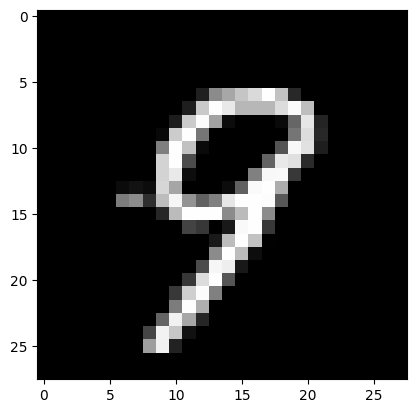

y: 7, y_hat: 7


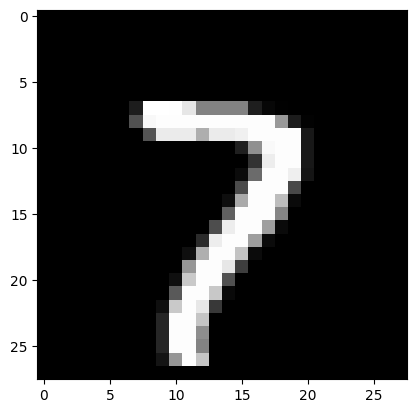

y: 8, y_hat: 8


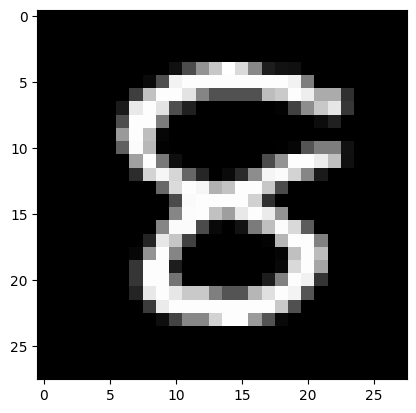

y: 7, y_hat: 7


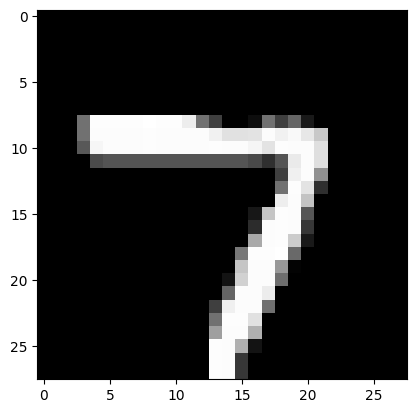

y: 7, y_hat: 7


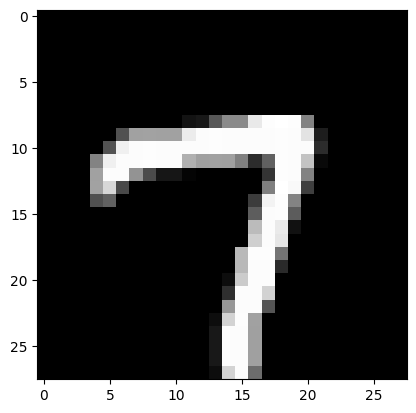

y: 5, y_hat: 5


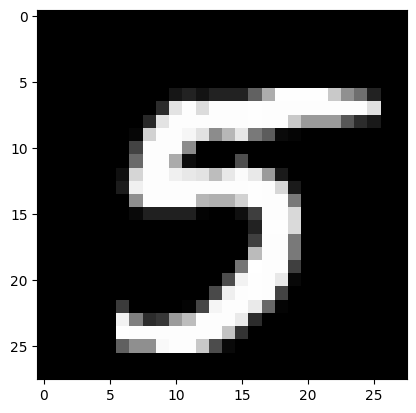

y: 0, y_hat: 0


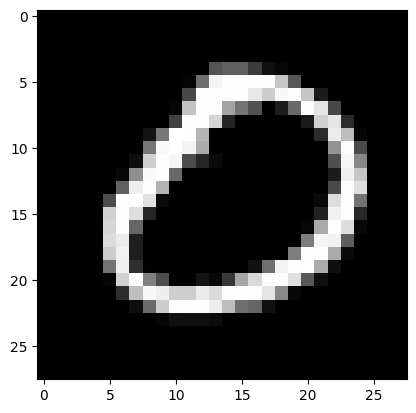

y: 8, y_hat: 8


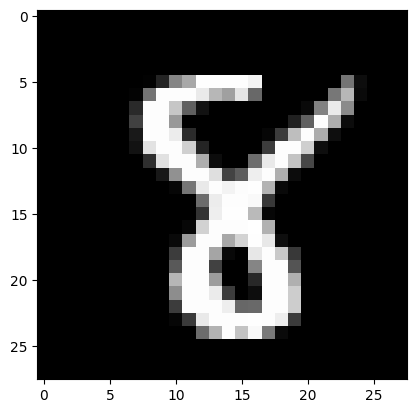

y: 6, y_hat: 6


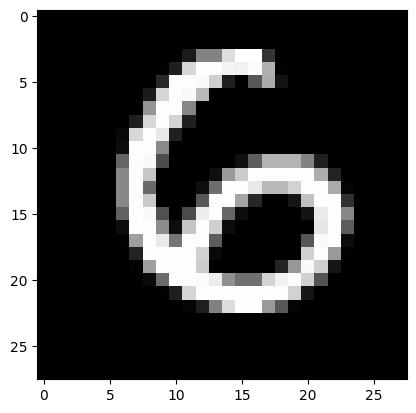

y: 2, y_hat: 2


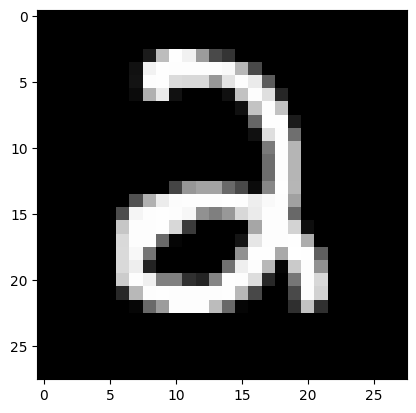

y: 5, y_hat: 5


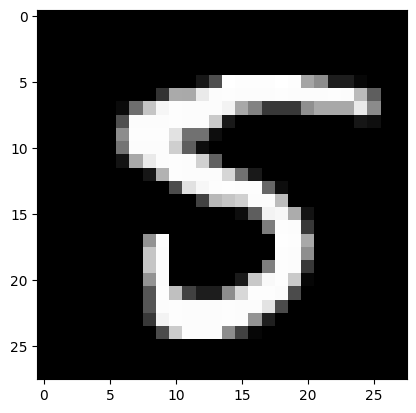

y: 3, y_hat: 9


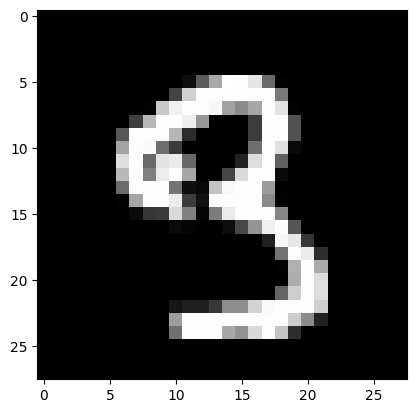

y: 8, y_hat: 8


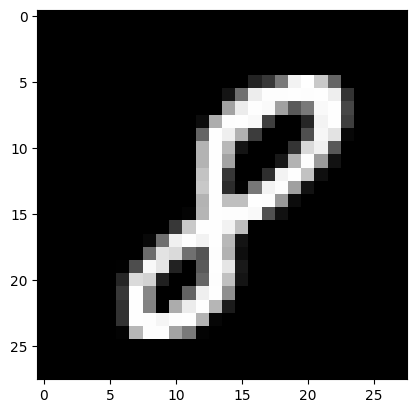

y: 7, y_hat: 7


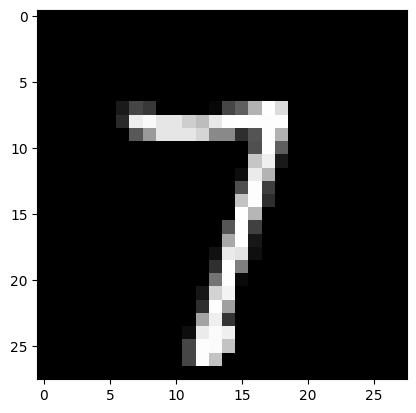

y: 9, y_hat: 9


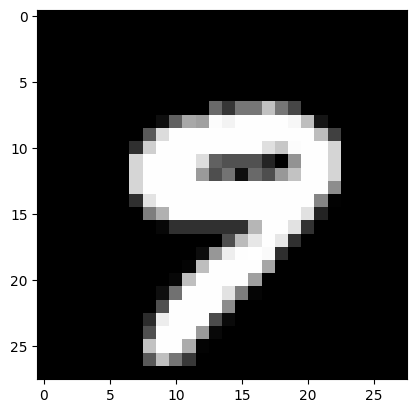

y: 6, y_hat: 6


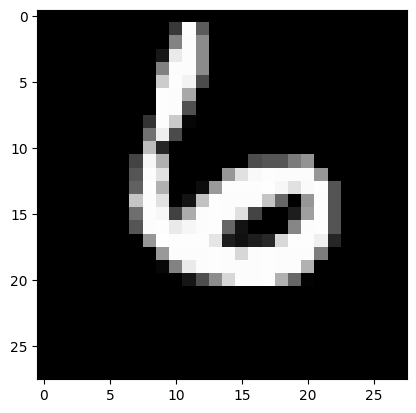

y: 6, y_hat: 6


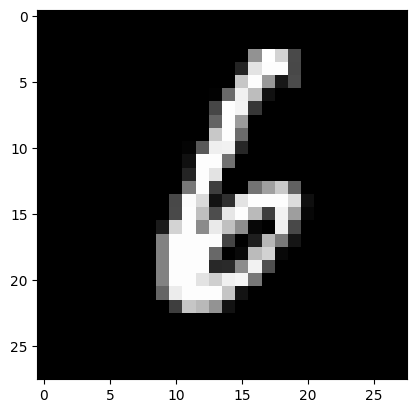

y: 6, y_hat: 6


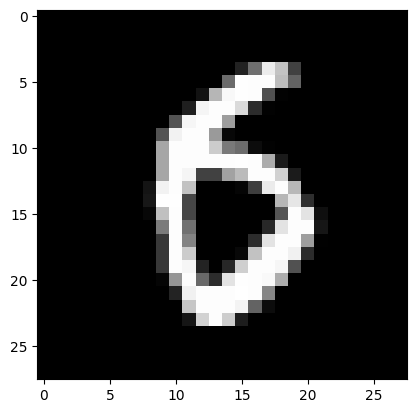

y: 3, y_hat: 3


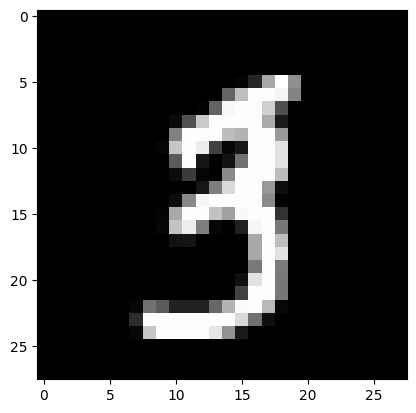

y: 4, y_hat: 4


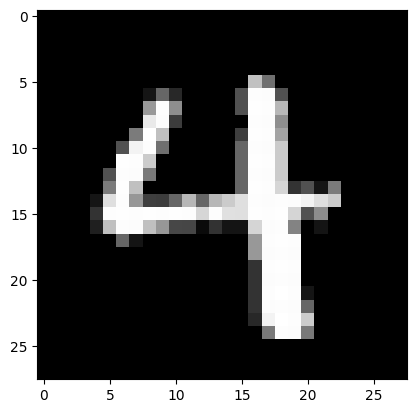

y: 2, y_hat: 2


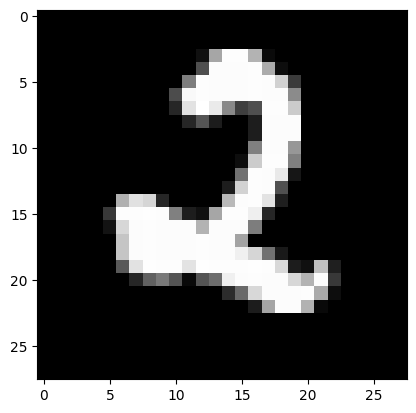

y: 1, y_hat: 1


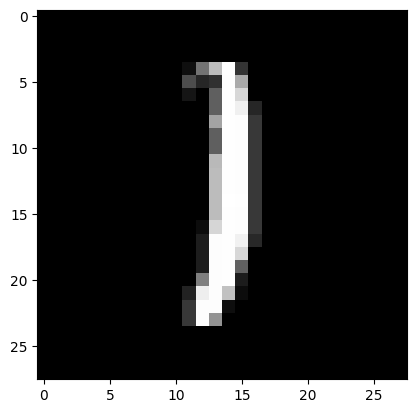

y: 9, y_hat: 9


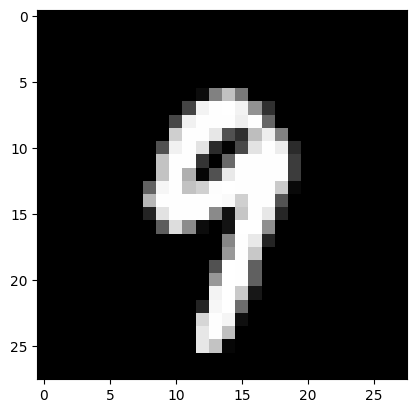

y: 9, y_hat: 9


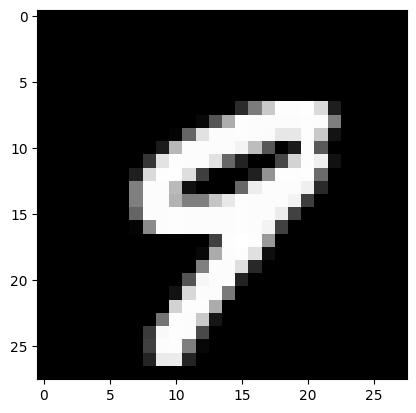

y: 3, y_hat: 3


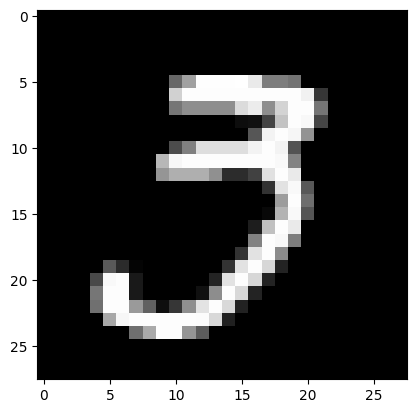

y: 8, y_hat: 8


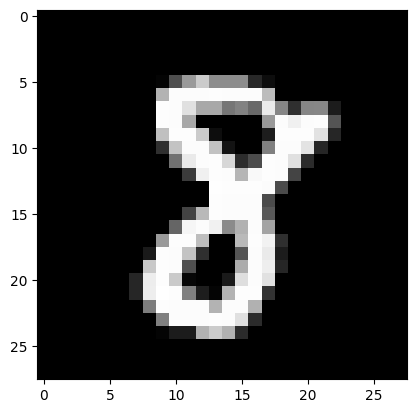

y: 7, y_hat: 7


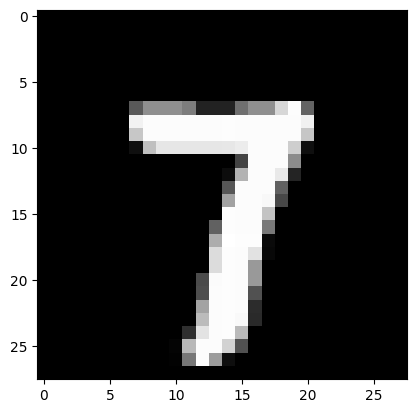

y: 2, y_hat: 2


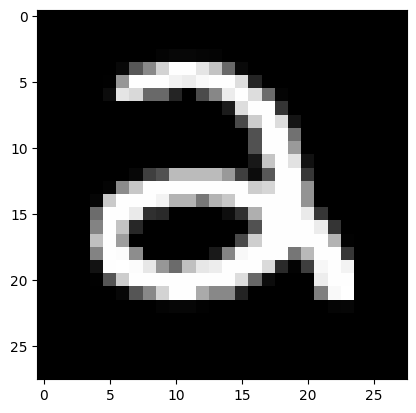

y: 4, y_hat: 4


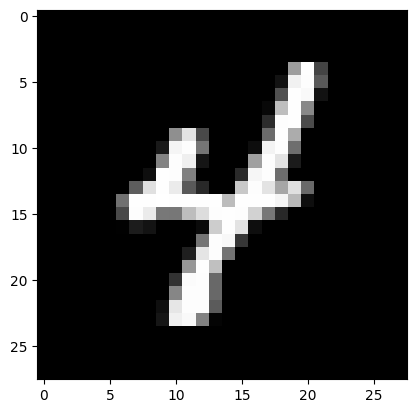

y: 3, y_hat: 3


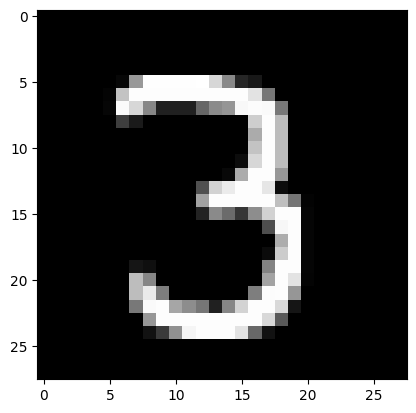

y: 8, y_hat: 8


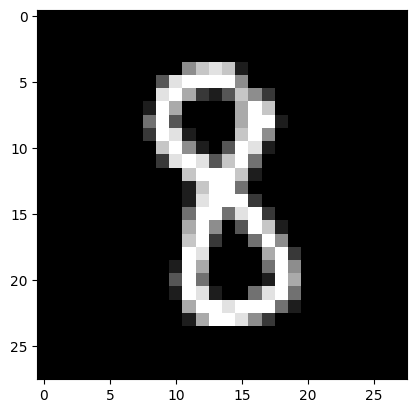

y: 3, y_hat: 3


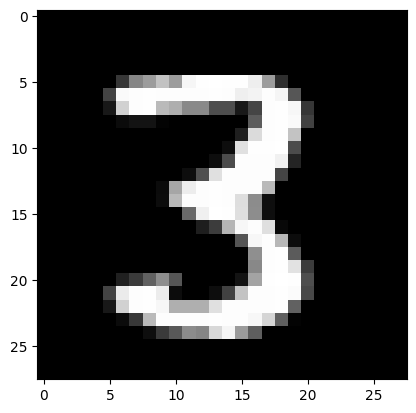

y: 0, y_hat: 0


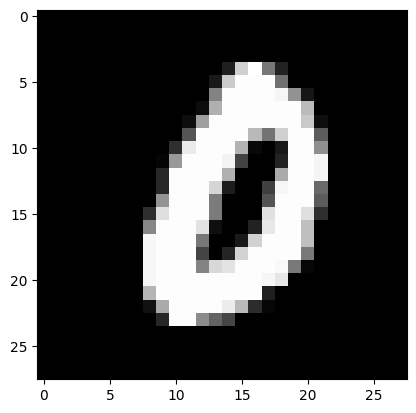

y: 4, y_hat: 4


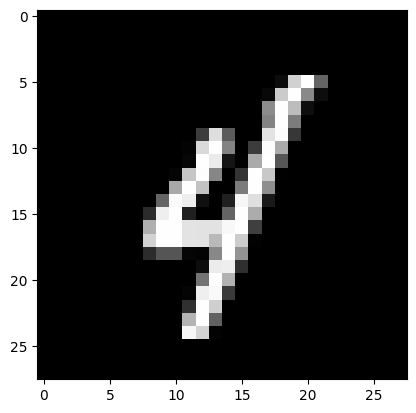

y: 5, y_hat: 5


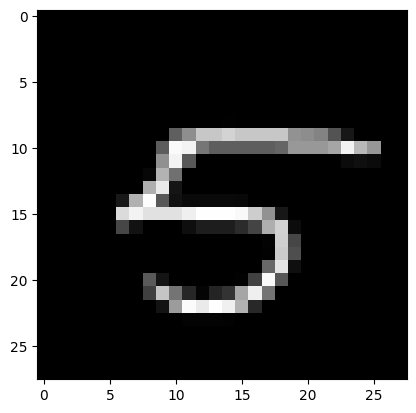

y: 1, y_hat: 1


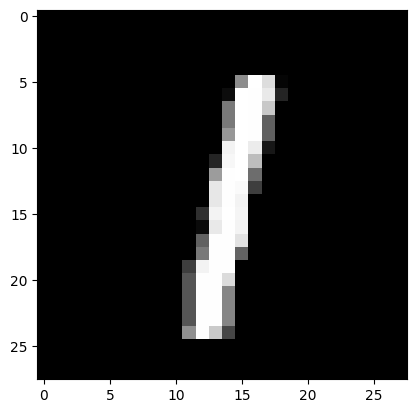

y: 2, y_hat: 2


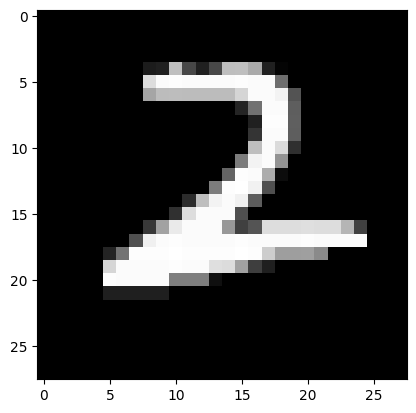

y: 4, y_hat: 4


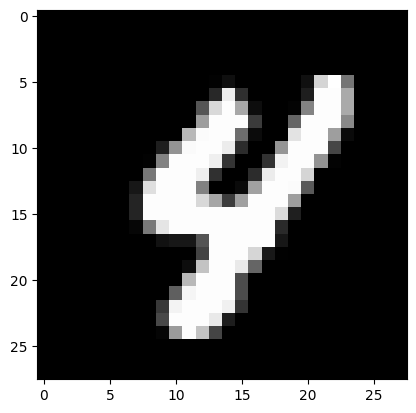

y: 3, y_hat: 3


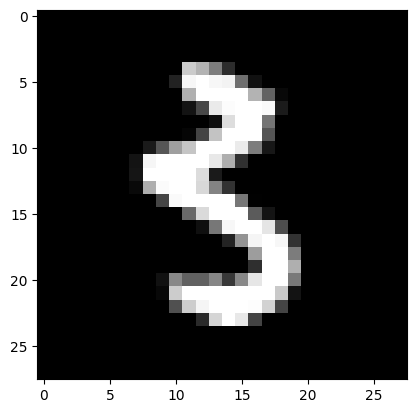

y: 0, y_hat: 0


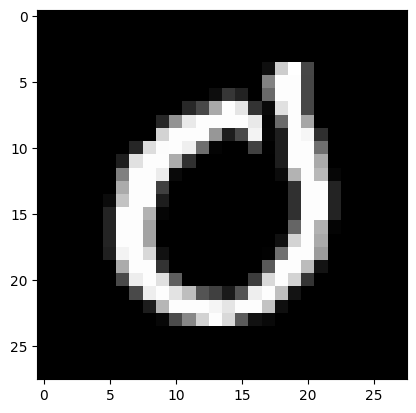

y: 5, y_hat: 5


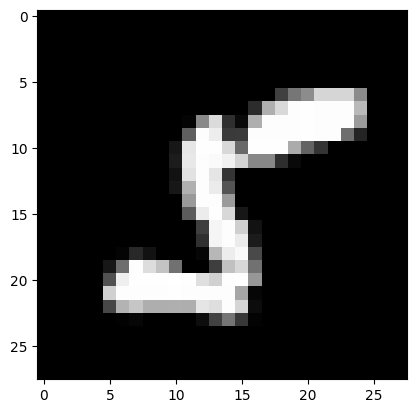

y: 1, y_hat: 1


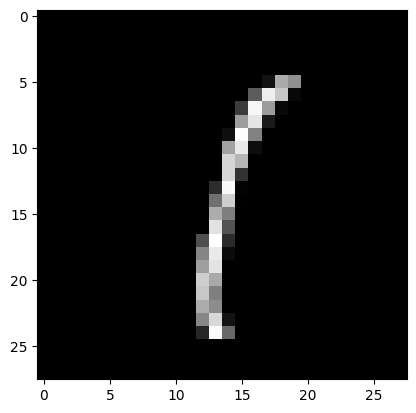

y: 4, y_hat: 4


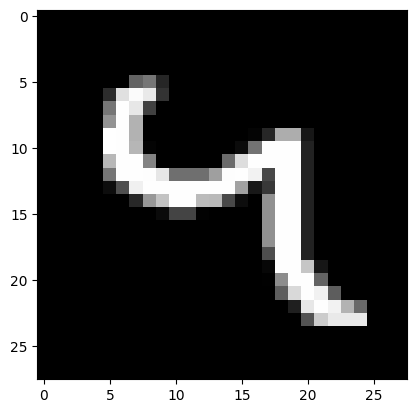

y: 5, y_hat: 5


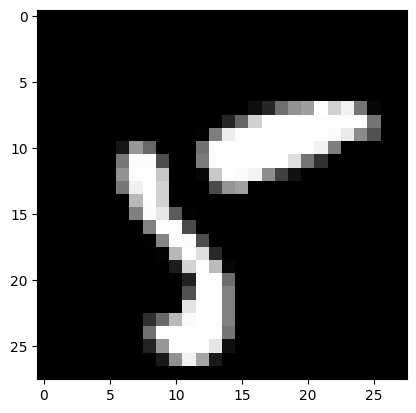

y: 6, y_hat: 6


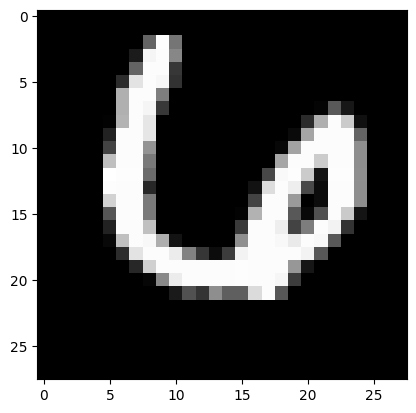

y: 7, y_hat: 7


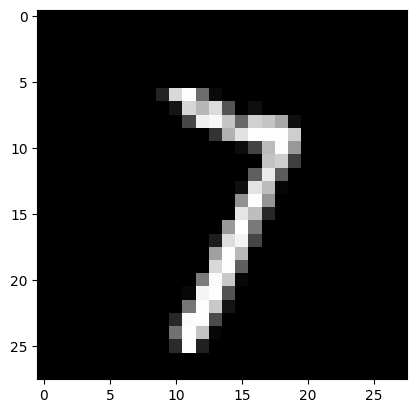

y: 3, y_hat: 3


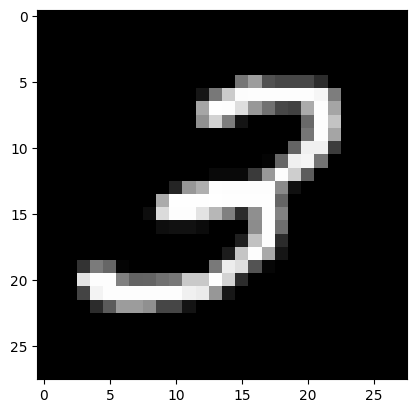

y: 5, y_hat: 5


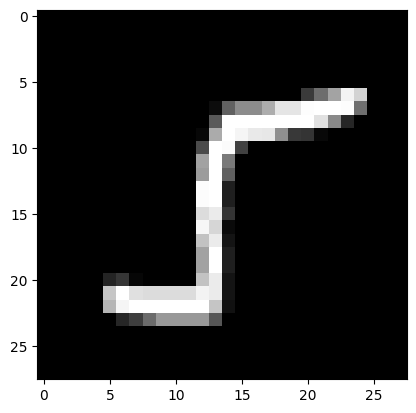

y: 5, y_hat: 5


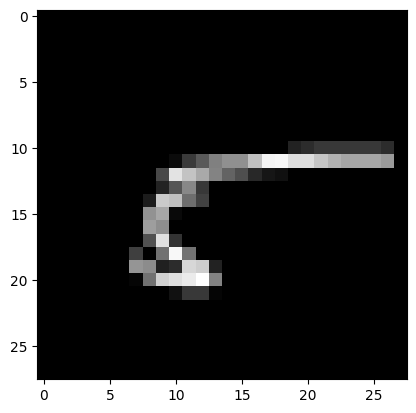

y: 5, y_hat: 5


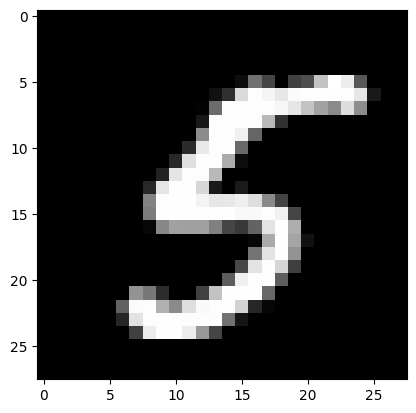

y: 0, y_hat: 0


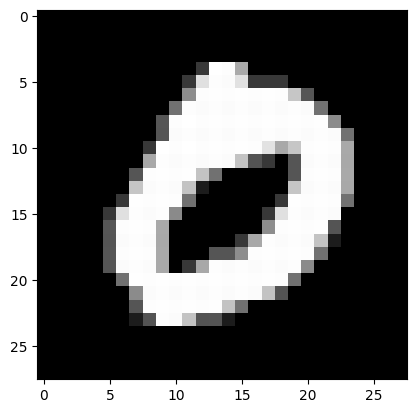

y: 7, y_hat: 7


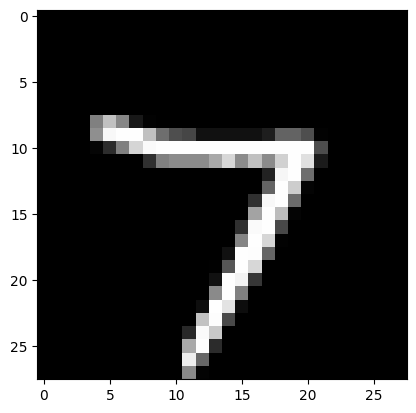

y: 6, y_hat: 6


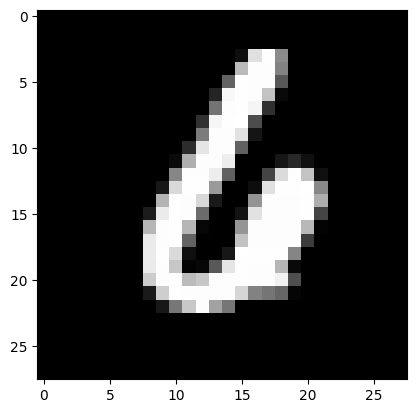

y: 3, y_hat: 3


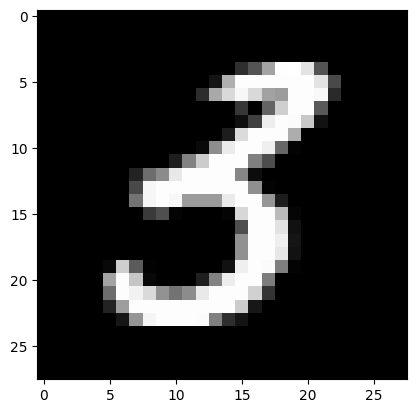

y: 1, y_hat: 1


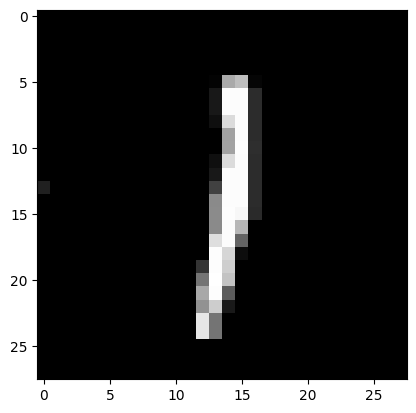

y: 2, y_hat: 2


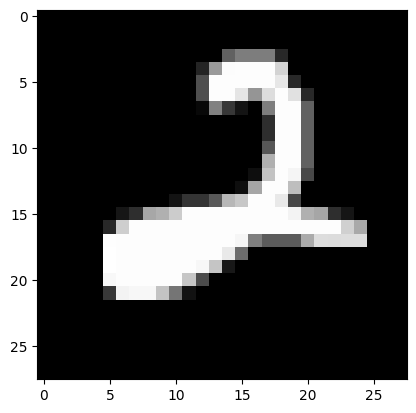

y: 4, y_hat: 4


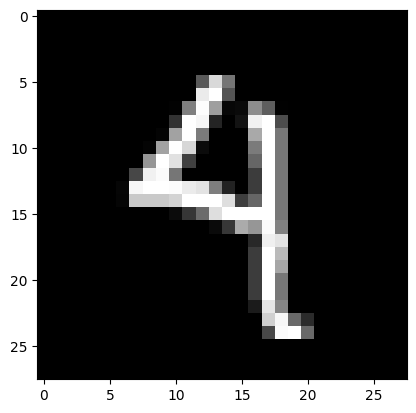

Epoch 16/16, Training Loss: 0.0003, Validation Loss: 0.0445, Validation Accuracy: 98.80%


In [ ]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in test_dl:
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        labels = labels.cpu().numpy()
        inputs = inputs.cpu().numpy()

        print(f"y: {labels[0]}, y_hat: {predicted[0]}")
        plt.imshow(inputs[0][0], cmap="gray")
        plt.show()

print(f'Epoch {epoch + 1}/{epochs}, '
      f'Training Loss: {loss.item():.4f}, '
      f'Validation Loss: {test_loss / len(test_dl):.4f}, '
      f'Validation Accuracy: {(correct / total) * 100:.2f}%')